In [1]:
# # For Colab

# !pip install transformers
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/Shareddrives/CS 401 Capstone project/Racial Bias/RB_dataset"

In [2]:
%cd "../../data/rb"

/Users/xieewenz/NoiseAndBias/data/rb


In [ ]:
import numpy as np
import pandas as pd
import time
import re
from tqdm import notebook
import seaborn as sns
import matplotlib.pyplot as plt

import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import gc

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [4]:
SEED = 875
seed_everything(SEED)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


# Dataset Loading & Processing

In [83]:
df = pd.read_csv('sap2019risk_mTurkExperiment.csv')
df.reset_index(inplace=True)
df['label'] = ((df['offensive2anyoneYN'] + df['offensive2youYN']) >= 1.0).astype(int)
df = df.rename(columns={'tweet': 'text', "index": "id"})
df.head(10)


,id,annotatorAge,annotatorGender,annotatorMinority,annotatorPolitics,annotatorRace,intentYN,offensive2anyoneYN,offensive2youYN,dialectIsWrong,raceIsWrong,WorkerIdHashed,text,dialect,condition,username,davidson_label,founta_label,label
0,0,31,man,{},liberal,white,0.000000,0.0,0.0,NaN,NaN,ab647dbde8ff4aab46c8cec7bdefad95,RT @user: When yo phone go off in class &amp; ...,NaN,text-only,A Twitter User,neither_rel,NaN,0
1,1,37,man,{},libert,white,0.000000,0.0,0.0,NaN,NaN,599ea0e2bcdac7f3458cb38410b08369,RT @user: When yo phone go off in class &amp; ...,NaN,text-only,A Twitter User,neither_rel,NaN,0
2,2,100,woman,{},liberal,asian,0.000000,0.0,0.0,NaN,NaN,652a3b795ccd59abc037cfbc94e77921,RT @user: When yo phone go off in class &amp; ...,NaN,text-only,A Twitter User,neither_rel,NaN,0
3,3,22,man,{},liberal,asian,0.666667,1.0,0.0,NaN,NaN,7bf3e76c903d5297d5b03b8615e1d489,@user yu forgot we beat yall? Thats like a gar...,NaN,text-only,A Twitter User,neither_rel,NaN,1
4,4,50,woman,sexuality,liberal,white,0.333333,0.5,0.0,NaN,NaN,342401c2a0796a7cbc2f4623a959e86b,@user yu forgot we beat yall? Thats like a gar...,NaN,text-only,A Twitter User,neither_rel,NaN,0
5,5,42,woman,{},cons,white,0.000000,0.0,0.0,NaN,NaN,e0f63929d8806fc6fe77999192de46d9,@user yu forgot we beat yall? Thats like a gar...,NaN,text-only,A Twitter User,neither_rel,NaN,0
6,6,26,woman,{},other,black,1.000000,1.0,1.0,NaN,NaN,c5cf8d242d8281d304987b12dc262f81,@user you look like fucking shrek bitch,NaN,text-only,A Twitter User,hate_speech_rel,NaN,1
7,7,35,woman,{},liberal,na,1.000000,1.0,1.0,NaN,NaN,51237cba56e29ee2da2247a53717201f,@user you look like fucking shrek bitch,NaN,text-only,A Twitter User,hate_speech_rel,NaN,1
8,8,37,man,{},libert,white,1.000000,1.0,1.0,NaN,NaN,599ea0e2bcdac7f3458cb38410b08369,@user you look like fucking shrek bitch,NaN,text-only,A Twitter User,hate_speech_rel,NaN,1
9,9,35,woman,{},liberal,white,0.333333,0.5,0.0,NaN,NaN,200f96fef14ef02c5962f147fd029820,"RT @user210: &#8220;@user: ""@user https://t.co...",NaN,text-only,A Twitter User,offensive_language_rel,NaN,0


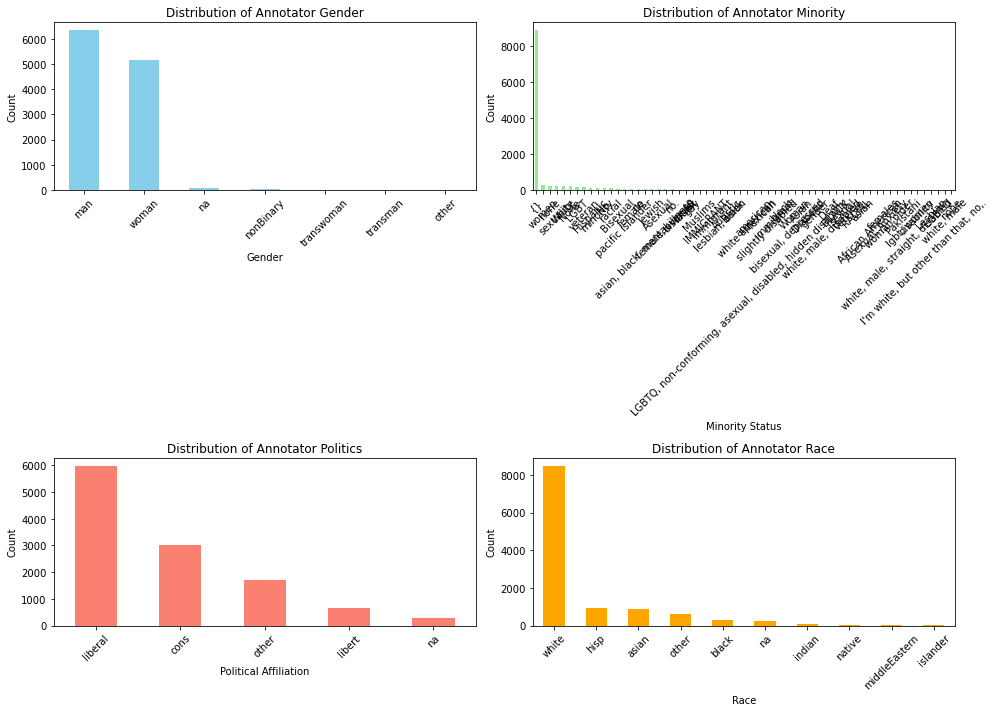

In [29]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot distribution of annotatorGender
df['annotatorGender'].value_counts().plot(kind='bar', color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Annotator Gender')
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot distribution of annotatorMinority
df['annotatorMinority'].value_counts().plot(kind='bar', color='lightgreen', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Annotator Minority')
axes[0, 1].set_xlabel('Minority Status')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot distribution of annotatorPolitics
df['annotatorPolitics'].value_counts().plot(kind='bar', color='salmon', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Annotator Politics')
axes[1, 0].set_xlabel('Political Affiliation')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot distribution of annotatorRace
df['annotatorRace'].value_counts().plot(kind='bar', color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Annotator Race')
axes[1, 1].set_xlabel('Race')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [6]:
# df = pd.read_csv('davidson_dial.csv')
# df = df[['id', 'tweet', "hate_speech_rel", "offensive_language_rel", "neither_rel", "class", "label"]]

# def get_agreement_factor(row):
#     return row[row['label']]


# df['agreement_factor'] = df.apply(get_agreement_factor, axis=1)
# df = df[['id', 'tweet', "class", "agreement_factor"]]
# df = df.rename(columns={'tweet': 'text', "class": "label"})
# df


,id,text,label,agreement_factor
0,0,!!! RT @mayasolovely: As a woman you shouldn't...,2,1.000000
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,1.000000
2,2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,1.000000
3,3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,0.666667
4,4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,1.000000
...,...,...,...,...
24778,25291,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1,0.666667
24779,25292,"you've gone and broke the wrong heart baby, an...",2,0.666667
24780,25294,young buck wanna eat!!.. dat nigguh like I ain...,1,1.000000
24781,25295,youu got wild bitches tellin you lies,1,1.000000


In [30]:
# df = df.head(2000)

from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# reindex train_df, val_df, and test_df to be from 0-len
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
print("Test data shape:", test_df.shape)


Train data shape: (9364, 19)
Validation data shape: (1171, 19)
Test data shape: (1171, 19)


In [82]:
train_df[["id", "text", "label"]]

,id,text,label
0,76,"RT @user: Cruising down the street in my 64, j...",1
1,10449,I am a fucking gem and if you think otherwise ...,0
2,7596,RT @user: Reason Why These Bitches Secretly Ha...,1
3,9429,You can't trust no chick that got a pet cat b ...,1
4,8642,RT @user10: &#8220;@user: Id rather be your ni...,1
...,...,...,...
9359,11284,RT @user: This what happens when you separate ...,1
9360,5191,"""@user10: &#8220;@user: Don't take advantage o...",0
9361,5390,@user that nigguh sucks,1
9362,860,"&#8220;@user210: ""@user: LMAO RT @user: Tempte...",1


# Model and Dataset

In [32]:
BERT = 'bert-base-uncased'
ROBERTA = 'roberta-base'

MODEL_NAME = ROBERTA

In [33]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
MAX_LEN = 256
EPOCHS = 20
LEARNING_RATE = 5e-5
NUM_LABELS = 2
EVAL_PERIOD = 100

In [36]:
# td =TextDataset(train_df, tokenizer, 2000)
# td[127]

In [37]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = self.df.loc[index, 'text']
        text_id = self.df.loc[index, 'id']
        target = self.df.loc[index, 'label']

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if MODEL_NAME=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids']
        else:
            token_type_ids = 1.

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long),
            'text_ids': text_id
        }

    def __len__(self):
        return self.len

In [38]:
class HateSpeechClassifier(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(HateSpeechClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name

        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(self.in_features, NUM_LABELS)

    def forward(self, input_ids, attention_mask, token_type_ids):
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)

        output = self.dropout(output)
        output = self.classifier(output)
        return output

# Training

In [39]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

valid_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

In [40]:
def get_train_setup(train_df, val_df):
    train_data = TextDataset(train_df, tokenizer, MAX_LEN)
    val_data = TextDataset(val_df, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_data, **train_params)
    val_loader = DataLoader(val_data, **valid_params)

    model = HateSpeechClassifier(MODEL_NAME)
    model.to(device)

    num_training_steps = EPOCHS*len(train_loader)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

    num_warmup_steps = 100
    scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_training_steps=num_training_steps,
        num_warmup_steps=num_warmup_steps,
    )

    return train_loader, val_loader, model, loss_function, optimizer, scheduler

In [41]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [42]:
from collections import defaultdict


def train(model, model_output_path, loss_fn, optimizer, scheduler, train_dataloader, val_dataloader=None, epochs=5, evaluation=False):

    print("Training...\n")
    train_values = defaultdict(lambda :torch.empty(0, dtype=torch.float))
    train_correctness = defaultdict(lambda :torch.empty(0, dtype=torch.float))

    best_val_loss = None
    best_val_accuracy = None

    for epoch in range(epochs):
        print(f"Length of Train Dataloader: {len(train_dataloader)}")
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        val_loss = None
        val_accuracy = None

        model.train()

        # epoch_train_values = torch.empty(0, dtype=torch.float)

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            text_ids = batch['text_ids'].unsqueeze(1)

            outputs = model(input_ids, attention_mask, token_type_ids)

            # print(f"outputs: {outputs.shape} {outputs}")
            # print(f"targets: {targets.shape} {targets}")

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())

            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            # cartography
            softmax_values = torch.nn.functional.softmax(outputs, dim=1)

            true_label_softmax_vals = softmax_values[torch.arange(softmax_values.size(0)), targets].unsqueeze(1)

            for tid, val in zip(text_ids, true_label_softmax_vals):
                train_values[tid.item()] = torch.cat((train_values[tid.item()], val.clone().detach().cpu())) # 32*2
            
            pred = torch.argmax(softmax_values, dim=1)
            correct = (pred == targets).int().unsqueeze(1)
            for tid, val in zip(text_ids, correct):
                train_correctness[tid.item()] = torch.cat((train_correctness[tid.item()], val.clone().detach().cpu())) # 32*2
            

            # batch_train_values = torch.cat((text_ids, true_label_softmax_vals.clone().detach().cpu()), dim=1) # 32*2

            # epoch_train_values = torch.cat((epoch_train_values, batch_train_values), dim = 0) # number of texts in train dataset * 2
            
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch

            if not best_val_loss or val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"\nBest model at epoch: {epoch + 1}")
                torch.save(model.state_dict(), model_path)

            if not best_val_accuracy or val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

            print(f"\n Validation Loss: {val_loss:^10.6f} | Validation Accuracy: {val_accuracy:^9.2f} | Time elasped: {time_elapsed:^9.2f}\n")


        avg_train_loss = total_loss / len(train_dataloader)
        print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {best_val_loss:^10.6f} | {best_val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

        print("-"*70)

        # train_values.append(epoch_train_values)
        print("\n")


    print("Training complete!")
    return train_values, best_val_loss, best_val_accuracy, train_correctness



In [43]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [44]:
def predict(model, loss_fn, dataloader):
    model.eval()

    test_accuracy = []
    test_loss = []
    test_preds = []

    for batch in dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        test_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        test_accuracy.append(calc_accuracy(max_ids, targets))
        test_preds.append([max_ids.cpu().detach().numpy().reshape(-1), targets.cpu().detach().numpy().reshape(-1)])

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy, test_preds

In [60]:
gc.collect()
model_path = f"model_{MODEL_NAME}_hate_speech_cls.pth"
train_loader, val_loader, model, loss_function, optimizer, scheduler = get_train_setup(
    train_df,
    val_df
)
train_values, best_val_loss, best_val_accuracy, train_correctness = train(
    model,
    model_path,
    loss_function,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    evaluation=True
)

Training...

Length of Train Dataloader: 293
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.390352   |     -      |     -     |   3.96   
   1    |   40    |   0.387418   |     -      |     -     |   3.70   
   1    |   60    |   0.390419   |     -      |     -     |   3.67   
   1    |   80    |   0.421751   |     -      |     -     |   3.79   
   1    |   100   |   0.406624   |     -      |     -     |   3.79   
   1    |   120   |   0.380276   |     -      |     -     |   3.71   
   1    |   140   |   0.383679   |     -      |     -     |   3.79   
   1    |   160   |   0.416799   |     -      |     -     |   3.78   
   1    |   180   |   0.368948   |     -      |     -     |   3.78   
   1    |   200   |   0.396075   |     -      |     -     |   3.70   
   1    |   220   |   0.370800   |     -      |     -     |   3.68   
   1    |   240   |   0.352959   |     -    

In [84]:
train_values

defaultdict(<function __main__.train.<locals>.<lambda>()>,
            {6340: tensor([0.6467, 0.7367, 0.7044, 0.6164, 0.7896, 0.6578, 0.5504, 0.7040, 0.6339,
                     0.6746]),
             9360: tensor([0.4755, 0.6437, 0.4662, 0.5265, 0.5061, 0.5550, 0.5064, 0.4242, 0.4782,
                     0.5529]),
             4059: tensor([0.8620, 0.9316, 0.9458, 0.9177, 0.8287, 0.9515, 0.8288, 0.9869, 0.8817,
                     0.6819]),
             4647: tensor([0.5831, 0.6700, 0.6358, 0.5764, 0.6460, 0.7236, 0.6137, 0.6372, 0.8111,
                     0.7666]),
             2349: tensor([0.7305, 0.9211, 0.8097, 0.8753, 0.8760, 0.8087, 0.8438, 0.9590, 0.6379,
                     0.7641]),
             1865: tensor([0.5475, 0.6035, 0.6501, 0.7585, 0.5839, 0.6910, 0.6586, 0.6584, 0.5267,
                     0.9287]),
             8219: tensor([0.7626, 0.9687, 0.9679, 0.9387, 0.7988, 0.9536, 0.8697, 0.9593, 0.8965,
                     0.7196]),
             10082: tensor([0.8

In [61]:
test_data = TextDataset(test_df, tokenizer, MAX_LEN)
test_loader = DataLoader(test_data, **test_params)

In [62]:
model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_1956162/2327528297.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [63]:
test_loss, test_accuracy, test_preds = predict(model, loss_function, test_loader)
test_loss, test_accuracy

(0.5088521556274311, 76.57361308677098)

In [64]:
preds = []
targets = []
for ele in test_preds:
    for p in ele[0]: preds.append(p)
    for p in ele[1]: targets.append(p)

preds_np = np.array(preds)
targets_np = np.array(targets)
print(preds_np.shape, targets_np.shape)

(1171,) (1171,)


In [65]:
print(f1_score(targets_np, preds_np, average="weighted"))

0.7668767396180595


In [66]:
print(classification_report(targets_np, preds_np,))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80       718
           1       0.67      0.78      0.72       453

    accuracy                           0.76      1171
   macro avg       0.76      0.77      0.76      1171
weighted avg       0.78      0.76      0.77      1171



# Analysis with Dataset Cartography

In [67]:
# Calculate mean and standard deviation for each id in train_df
cartography_df = train_df.copy()
cartography_df['confidence'] = cartography_df['id'].apply(lambda x: train_values[x].mean().item())
cartography_df['variability'] = cartography_df['id'].apply(lambda x: train_values[x].std().item())
cartography_df['correctness'] = cartography_df['id'].apply(lambda x: train_correctness[x].mean().item())
cartography_df['is_correct'] = cartography_df['id'].apply(lambda x: train_correctness[x][-1].item())
cartography_df

,id,annotatorAge,annotatorGender,annotatorMinority,annotatorPolitics,annotatorRace,intentYN,offensive2anyoneYN,offensive2youYN,dialectIsWrong,...,dialect,condition,username,davidson_label,founta_label,label,confidence,variability,correctness,is_correct
0,76,27,man,{},cons,white,1.000000,1.0,1.0,NaN,...,NaN,text-only,A Twitter User,offensive_language_rel,NaN,1,0.639324,0.097610,1.0,1.0
1,10449,23,man,White,cons,white,0.000000,0.0,0.0,NaN,...,General American,race-priming,a Twitter user that is likely White/Caucasian,NaN,abusive,0,0.880237,0.123092,1.0,1.0
2,7596,27,man,{},liberal,hisp,0.333333,0.5,0.5,NaN,...,African-American,dialect-priming,A Twitter User,NaN,hateful,1,0.685677,0.096229,1.0,1.0
3,9429,30,man,{},libert,white,0.333333,1.0,0.0,NaN,...,African-American,race-priming,a Twitter user that is likely Black/African-Am...,offensive_language_rel,NaN,1,0.583427,0.119548,0.9,0.0
4,8642,22,man,{},other,white,0.333333,1.0,0.0,NaN,...,NaN,race-priming,a Twitter user,offensive_language_rel,NaN,1,0.552099,0.090007,0.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9359,11284,40,woman,{},cons,white,1.000000,1.0,0.5,NaN,...,African-American,race-priming,a Twitter user that is likely Black/African-Am...,NaN,hateful,1,0.497542,0.061021,0.4,0.0
9360,5191,26,man,none,liberal,white,0.000000,0.0,0.0,NaN,...,NaN,dialect-priming,A Twitter User,offensive_language_rel,NaN,0,0.540711,0.114374,0.6,0.0
9361,5390,39,man,NaN,other,white,0.666667,1.0,0.0,NaN,...,Latino,dialect-priming,A Twitter User,offensive_language_rel,NaN,1,0.845412,0.092619,1.0,1.0
9362,860,22,man,{},liberal,asian,0.666667,1.0,0.0,NaN,...,NaN,text-only,A Twitter User,offensive_language_rel,NaN,1,0.904449,0.077000,1.0,1.0


train_values = [[[1, 0.8, 0.2],[2, 0.8, 0.2]], [[1, 0.8, 0.2],[2, 0.8, 0.2]], [[1, 0.8, 0.2],[2, 0.8, 0.2]]] .. correct prediction for 1 = 0, 2 = 1

In [68]:
cartography_df.to_csv('rb-data-cartography_10_epochs.csv')

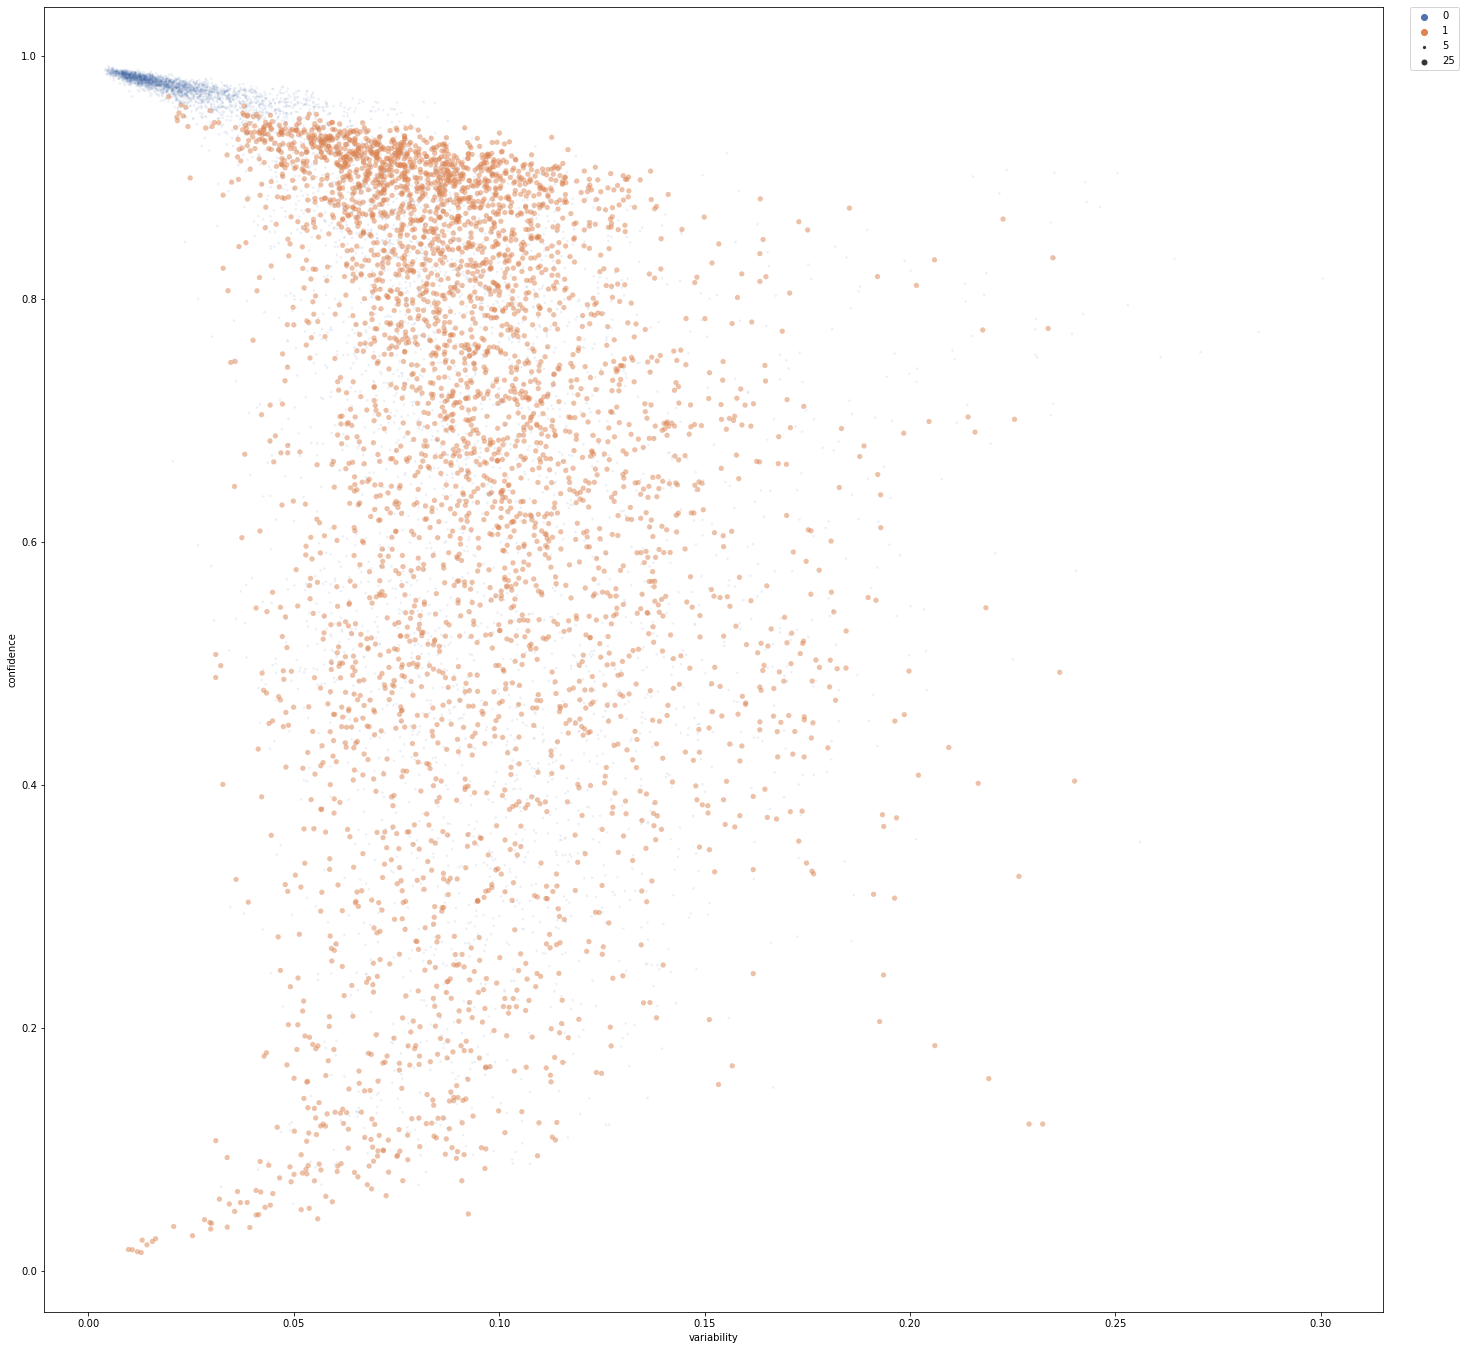

In [95]:

# Define a function to adjust the size of the markers based on the label
def adjust_marker_size_by_label(label):
    if label == 0:
        return 5  # Size for label 0
    elif label == 1:
        return 25  # Size for label 1
    else:
        return 10  # Default size for other labels if any


# Define a function to adjust the alpha of the markers based on the label
def adjust_alpha_by_label(label):
    if label == 0:
        return 0.1  # Alpha for label 0
    elif label == 1:
        return 0.5  # Alpha for label 1
    else:
        return 0.7  # Default alpha for other labels if any

# Apply the function to the 'label' column to get sizes and alphas
label_sizes = cartography_df['label'].apply(adjust_marker_size_by_label)
label_alphas = cartography_df['label'].apply(adjust_alpha_by_label)

plt.figure(figsize=(24, 24))
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='label', size=label_sizes, sizes=(5, 25), palette='deep', alpha=label_alphas, edgecolor=None)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


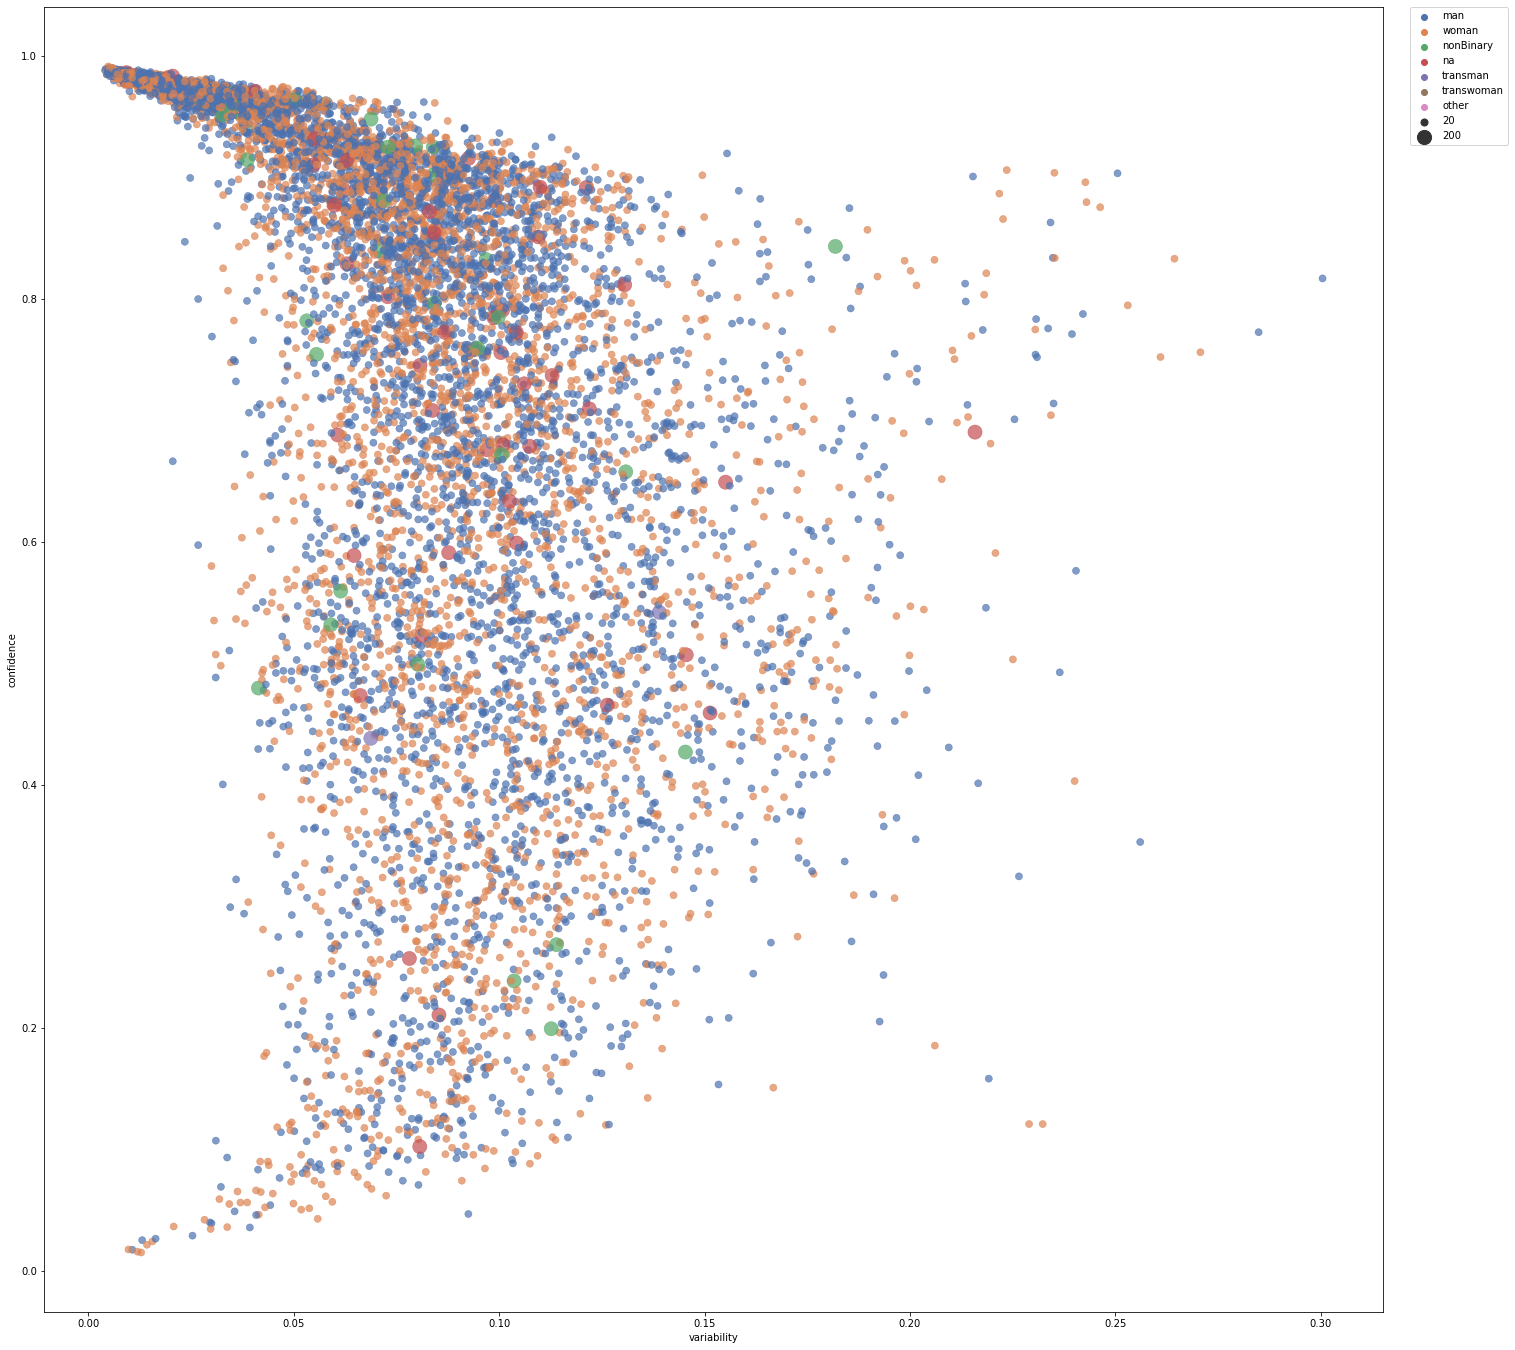

In [86]:
plt.figure(figsize=(24, 24))

# Define a function to adjust the size of the markers based on the annotatorGender
def adjust_marker_size(gender):
    if gender in ['man', 'woman']:
        return 20  # Smaller size for 'man' and 'woman'
    else:
        return 200  # Larger size for other minority labels

# Apply the function to the 'annotatorGender' column to get sizes
sizes = cartography_df['annotatorGender'].apply(adjust_marker_size)

sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='annotatorGender', size=sizes, sizes=(50, 200), palette='deep', alpha=0.7, edgecolor=None)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

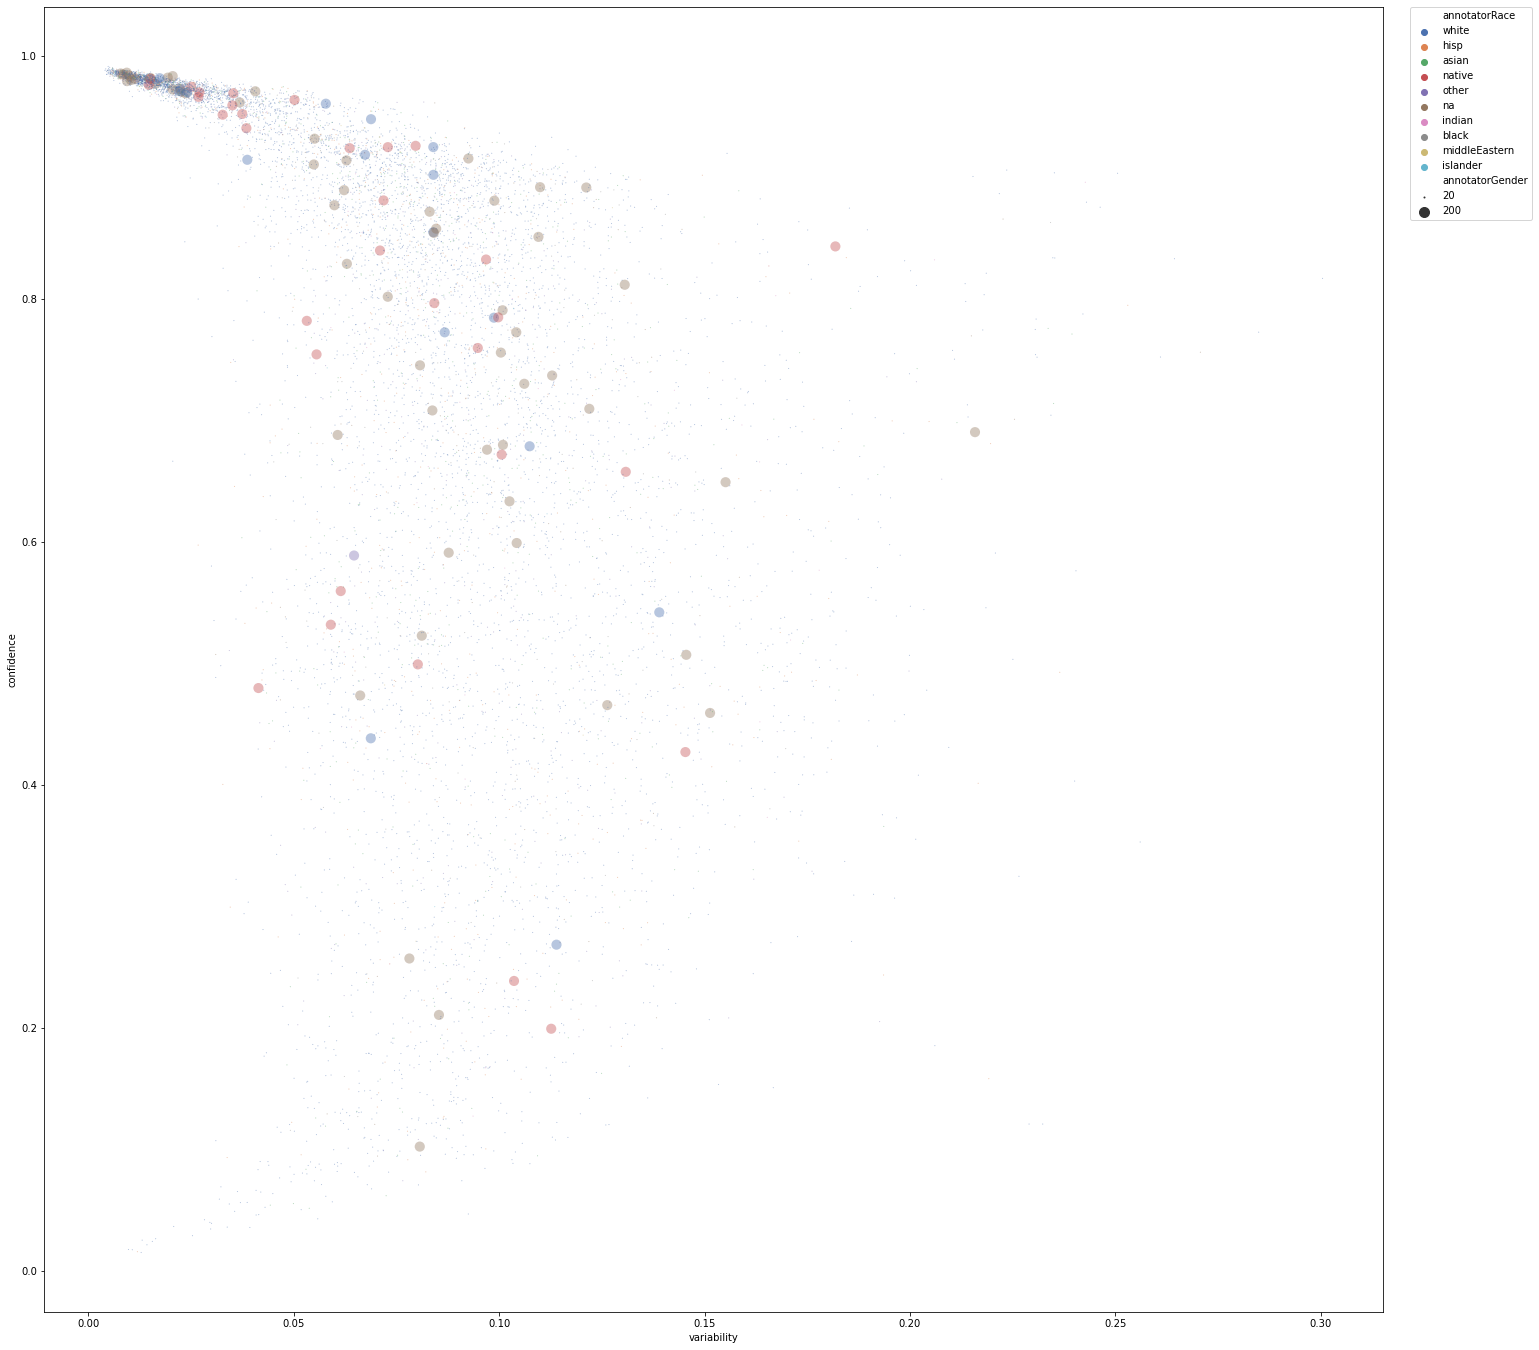

In [90]:
def adjustsize(race):
    if race == "white":
        return 1
    else:
        return 100

def adjustalpha(race):
    if race == "white":
        return 0.1
    else:
        return 1.0

size = cartography_df["annotatorRace"].apply(adjustsize)


plt.figure(figsize=(24, 24))
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='annotatorRace', size=sizes, sizes=(1, 100) ,palette='deep', alpha=0.4, edgecolor=None)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

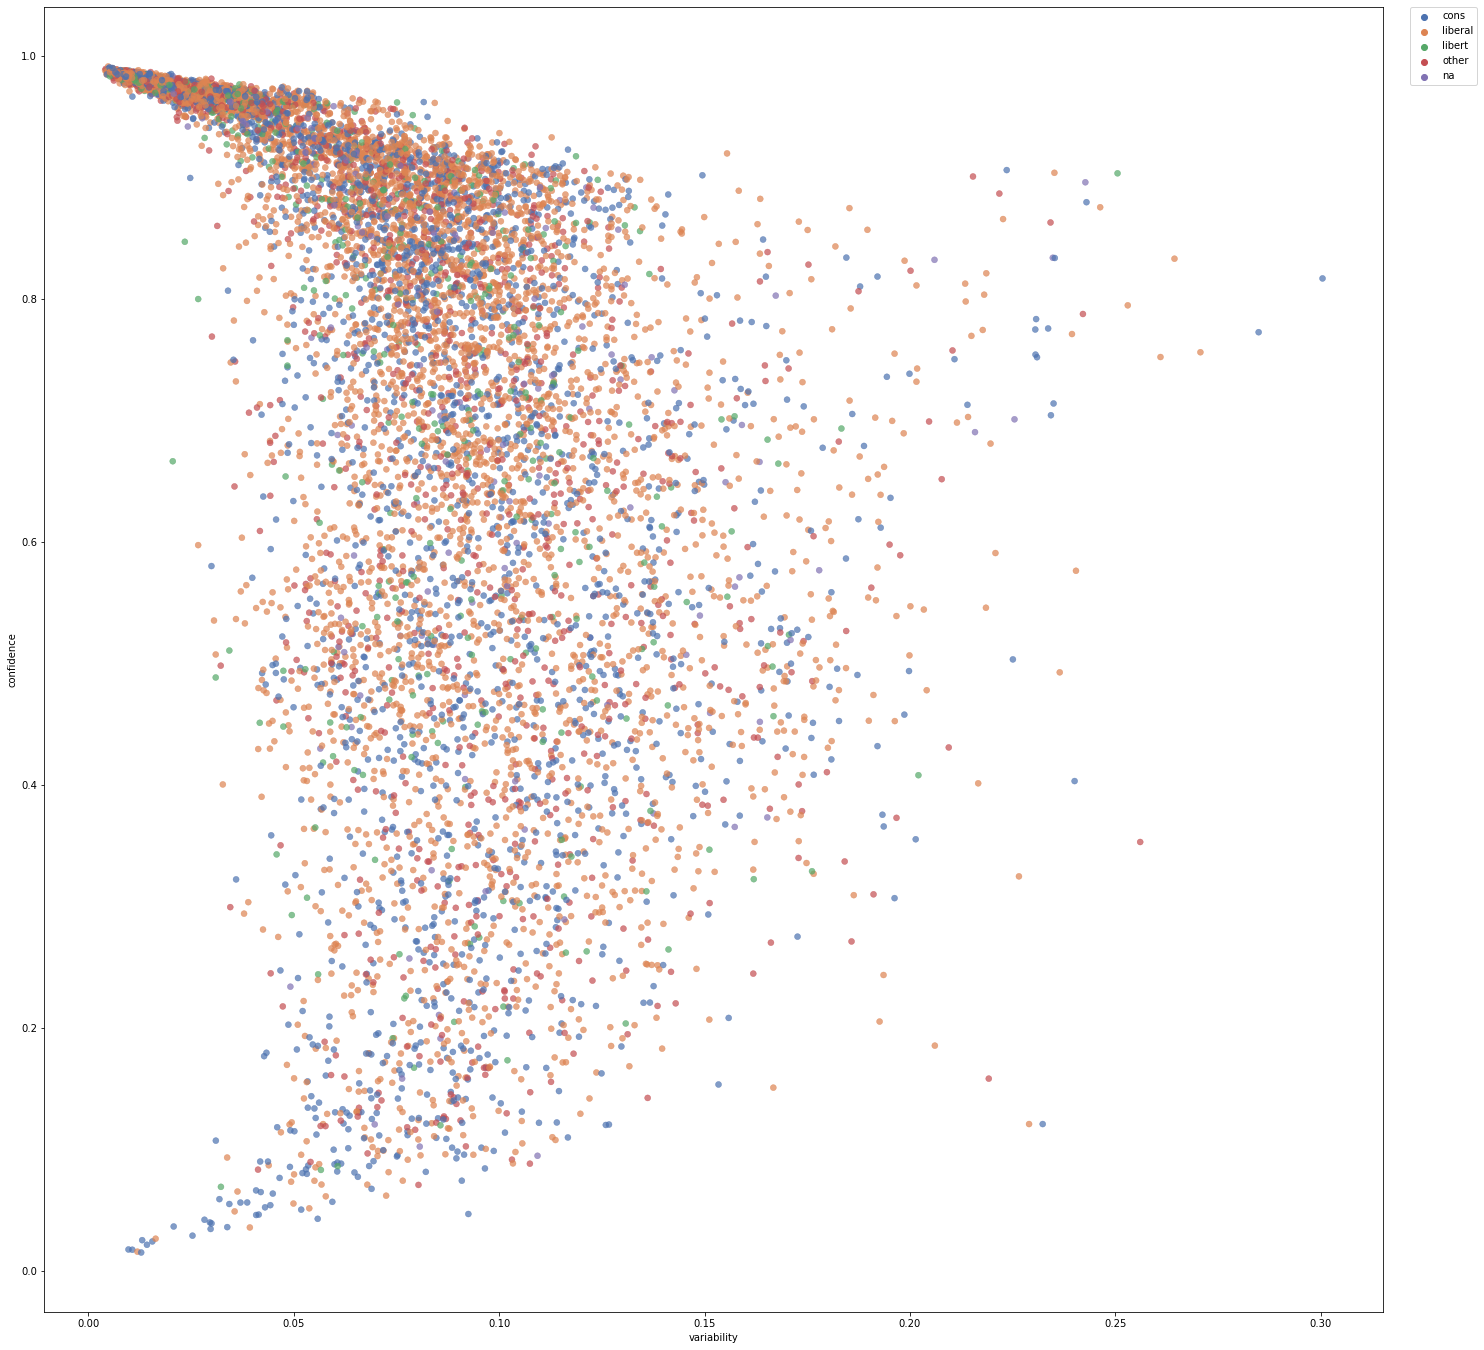

In [79]:
plt.figure(figsize=(24, 24))
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='annotatorPolitics', palette='deep', alpha=0.7, edgecolor=None)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

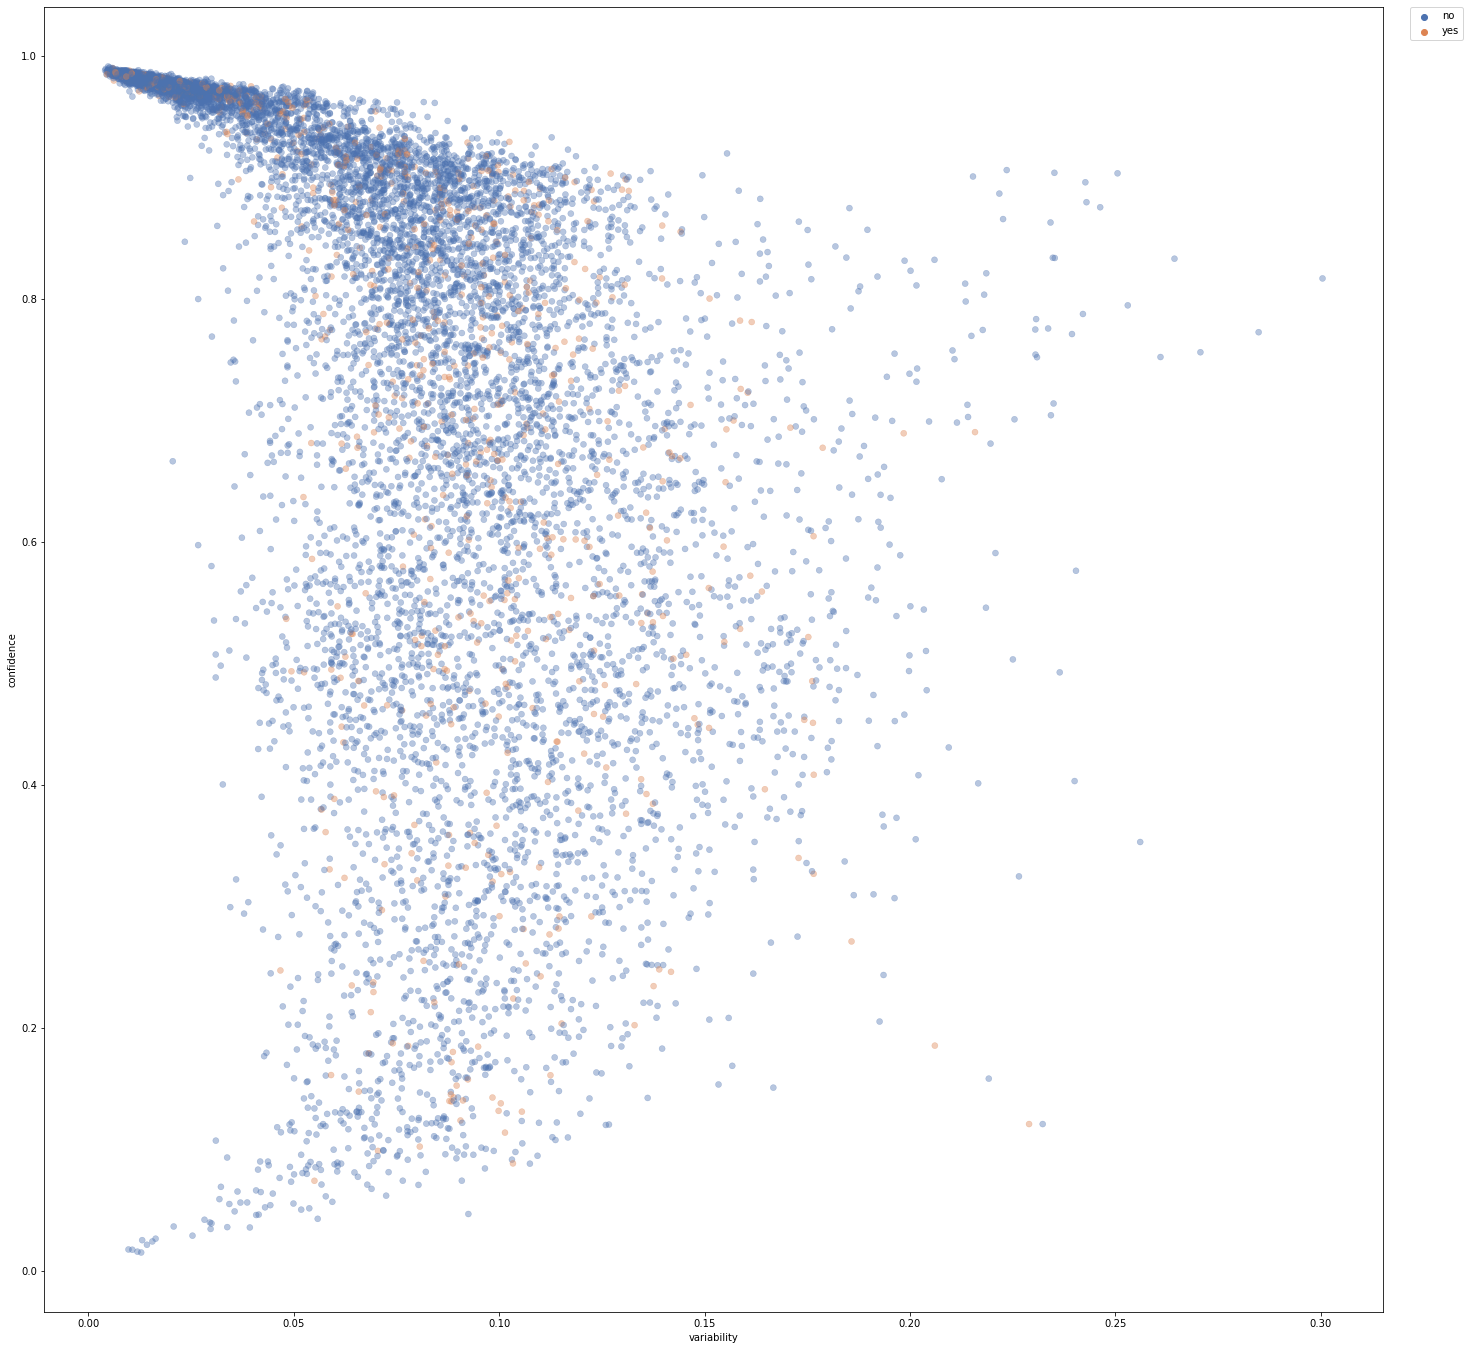

In [98]:
# Consolidate minority annotation into 'yes' or 'no'
cartography_df['annotatorMinority'] = cartography_df['annotatorMinority'].apply(
    lambda x: 'yes' if pd.isna(x) or x in [None, 'none', 'None', 'no', 'White', 'white', "no."] else 'no'

)

plt.figure(figsize=(24, 24))
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='annotatorMinority', palette='deep', alpha=0.4, edgecolor=None)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

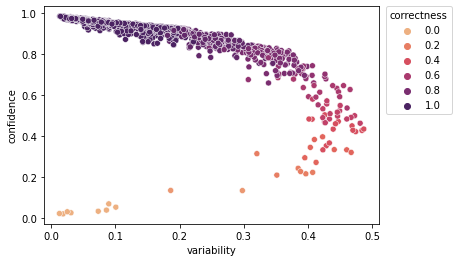

In [33]:
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='correctness', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='correctness')
plt.savefig("conf_vs_var_color_correctness.png", dpi=600, bbox_inches='tight')

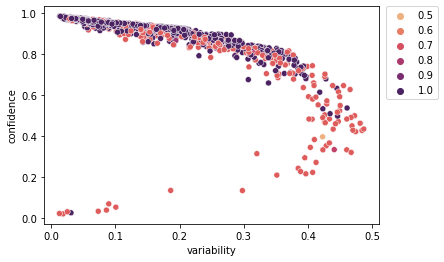

In [34]:
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='agreement_factor', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("conf_vs_var_color_agreement_factor.png", dpi=600, bbox_inches='tight')

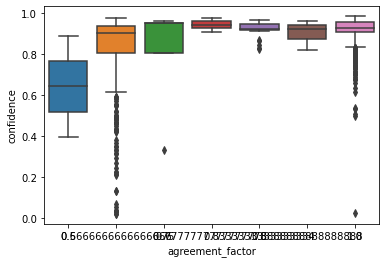

In [35]:
sns.boxplot(cartography_df, x='agreement_factor', y='confidence')
plt.savefig("conf_vs_agreement_factor.png", dpi=600, bbox_inches='tight')

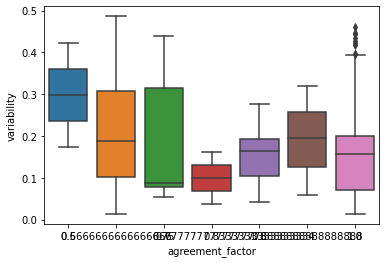

In [36]:
sns.boxplot(cartography_df, x='agreement_factor', y='variability')
plt.savefig("var_vs_agreement_factor.png", dpi=600, bbox_inches='tight')

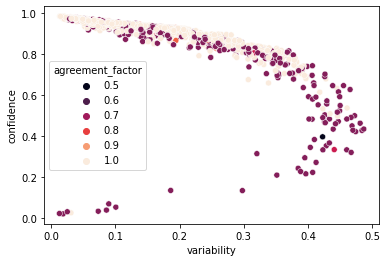

In [38]:
g = sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='agreement_factor', palette='rocket')
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels = ['A++','A+','A+0', 'A0'], title='agreement_level')
plt.savefig("conf_vs_var_color_agreement_level.png", dpi=600, bbox_inches='tight')

In [39]:
cartography_df.head()

,id,text,label,agreement_factor,confidence,variability,correctness,is_correct
0,990,&#128514; RT @LaShana_Sinead: Mimi too old to ...,1,0.666667,0.920731,0.187654,1.0,1.0
1,242,"""@SportsCenter: Eli Manning just threw his NFL...",2,0.666667,0.894522,0.227647,0.9,1.0
2,836,"#Yankees take all three games in MoTown, I'm c...",2,1.000000,0.878518,0.220519,0.9,1.0
3,702,#DearFeministMen there are easier way to get p...,1,0.833333,0.925650,0.189508,1.0,1.0
4,426,"""Ain't that about a bitch""... What does that m...",1,1.000000,0.916093,0.192074,1.0,1.0


In [41]:
cartography_df.sort_values(['confidence']).head(10)

,id,text,label,agreement_factor,confidence,variability,correctness,is_correct
789,1308,&#8220;@GlitteredInPink: @West305 you like 5'8...,0,0.666667,0.021216,0.018840,0.0,0.0
1381,1964,&#8220;@thejanicexxx: o u unfollowed me so i c...,0,0.666667,0.023323,0.013183,0.0,0.0
717,111,"""@DevilGrimz: @VigxRArts you're fucking gay, b...",0,1.000000,0.026753,0.031154,0.0,0.0
1307,1668,&#8220;@_BitchBUH: Shoot that nigga and his sh...,0,0.666667,0.031725,0.025397,0.0,0.0
1083,645,"""fuck you you pussy ass hater go suck a dick a...",0,0.666667,0.034329,0.073559,0.0,0.0
1539,656,"""on my way to fuck your bitch in the name of T...",0,0.666667,0.039837,0.086322,0.0,0.0
451,1010,&#128514;&#128514;&#128514; i just said that R...,0,0.666667,0.054205,0.100912,0.0,0.0
932,1576,&#8220;@TP_Three: @WestSideFlee @KekePalmer da...,0,0.666667,0.070313,0.089927,0.0,0.0
43,624,"""You ol trout mouth ass bitch"" \nDEEEEAAAADD",0,0.666667,0.135052,0.297744,0.1,1.0
426,1729,&#8220;@alicia_688: You aint special niglet RT...,0,0.666667,0.135822,0.186226,0.1,0.0
